### 导入依赖

In [1]:
import pandas as pd
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from matplotlib import pyplot as plt
import numpy as np
import datetime
import pylab

E:\Anaconda3Install\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
E:\Anaconda3Install\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
E:\Anaconda3Install\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
E:\Anaconda3Install\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1ty

In [2]:
print(tf.__version__)

1.13.1


### 查看数据

In [4]:
mnist = input_data.read_data_sets(
    'data/fashion', source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/', one_hot=True)
# mnist = input_data.read_data_sets('fashion', one_hot=True)
print(' 输入数据：', mnist.train.images.shape)

# train = mnist.train.images
# test = mnist.test.images
# print(' train_shape :', train.shape)
# print(' test_shape :', test.shape)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting data/fashion\train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting data/fashion\t10k-images-idx3-ubyte.gz
Extracting data/fashion\t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
 输入数据： (55000, 784)


### 查看图片

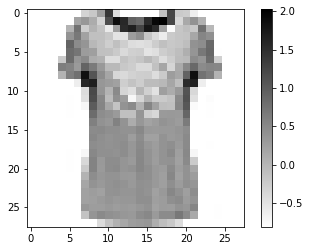

In [6]:
# 数据归一化
from sklearn.preprocessing import StandardScaler

standardScaler = StandardScaler()
mnist_train = standardScaler.fit_transform(mnist.train.images.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
# 展示一下这个数据集的图像
def show_single_image(img_arr):
    plt.imshow(img_arr,cmap="binary")
    plt.colorbar()
    plt.show()
show_single_image(mnist_train[1])

In [ ]:
# 构造池化函数
def weight_variable(shape):
    # Outputs random values from a truncated normal distribution.
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)


# 构造偏差b函数
def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)  # Creates a constant tensor
    return tf.Variable(initial)


# 构造卷积函数，输入x,w 与 padding 的形式
def conv2d(x, W, padding):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1],
                        padding=padding)  # input tensor, filter tensor, strides: sliding window, padding algorithm 'same' 'valid'


# 构造池化函数, kernel size=2*2
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')


sess = tf.InteractiveSession()
Dropout_Rate = tf.placeholder(tf.float32)

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

W_conv1 = weight_variable([5, 5, 1, 24])
b_conv1 = bias_variable([24])

x_image = tf.reshape(x, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1, 'SAME') + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

W_conv2 = weight_variable([3, 3, 24, 48])
b_conv2 = bias_variable([48])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2, 'SAME') + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

W_fc1 = weight_variable([7 * 7 * 48, 256])
b_fc1 = bias_variable([256])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 48])

dfc1 = tf.nn.dropout(h_pool2_flat, keep_prob=Dropout_Rate)
h_fc1 = tf.nn.relu(tf.matmul(dfc1, W_fc1) + b_fc1)

# h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

W_fc2 = weight_variable([256, 128])
b_fc2 = bias_variable([128])

dfc2 = tf.nn.dropout(h_fc1, keep_prob=Dropout_Rate)
h_fc2 = tf.nn.relu(tf.matmul(dfc2, W_fc2) + b_fc2)

# h_fc2 = tf.nn.relu(tf.matmul(h_fc1, W_fc2) + b_fc2)

W_fc3 = weight_variable([128, 10])
b_fc3 = bias_variable([10])

y_conv = tf.nn.softmax(tf.matmul(h_fc2, W_fc3) + b_fc3)

loss = -tf.reduce_sum(y_ * tf.log(tf.clip_by_value(y_conv, 10e-8, 1. - 10e-8)))
equal = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(equal, tf.float32))

train_step = tf.train.AdamOptimizer(5 * 1e-4).minimize(loss)

sess.run(tf.global_variables_initializer())
tr_ac = []
te_ac = []
tr_lo = []
te_lo = []
batchNum = 256

starttime = datetime.datetime.now()

for i in range(40000):
    batch = mnist.train.next_batch(batchNum)
    if i % 2000 == 0:
        train_accuracy = accuracy.eval(feed_dict={x: batch[0],
                                                  y_: batch[1], Dropout_Rate: 1})
        train_loss = loss.eval(feed_dict={x: batch[0],
                                          y_: batch[1], Dropout_Rate: 1}) / batchNum
        a = 10
        b = batchNum
        s = 0
        sl = 0
        for k in range(a):
            testSet = mnist.test.next_batch(b)
            c = accuracy.eval(
                feed_dict={x: testSet[0], y_: testSet[1], Dropout_Rate: 1})
            cl = loss.eval(
                feed_dict={x: testSet[0], y_: testSet[1], Dropout_Rate: 1})
            sl += cl * b
            s += c * b
        test_accuracy = (s / (b * a))
        test_loss = (sl / (b * a) / batchNum)
        print("step %d, train accuracy %g, test accuracy %g" %
              (i, train_accuracy, test_accuracy))
        #        print("step %d, train loss %g, test loss %g" % (i,train_loss, test_loss))
        tr_ac.append(train_accuracy)
        te_ac.append(test_accuracy)
        tr_lo.append(train_loss)
        te_lo.append(test_loss)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], Dropout_Rate: 0.3})

endtime = datetime.datetime.now()

# 使用matplot画出损失的变化曲线图
plt.figure(figsize=(16, 5))
plt.plot(np.squeeze(tr_ac), color='#2A688B')
plt.plot(np.squeeze(te_ac), color="#F08080")
plt.xlim(0, 19)
plt.ylabel("accuracy")
plt.xlabel("iterations")
plt.savefig('accuracy', dpi=300)
plt.show()

plt.figure(figsize=(16, 5))
plt.plot(np.squeeze(tr_lo), color='#2A688B')
plt.plot(np.squeeze(te_lo), color="#F08080")
plt.xlim(0, 19)
plt.ylabel("loss")
plt.xlabel("iterations")
plt.savefig('loss', dpi=300)
plt.show()

a = 10
b = batchNum
s = 0
for i in range(a):
    testSet = mnist.test.next_batch(b)
    c = accuracy.eval(
        feed_dict={x: testSet[0], y_: testSet[1], Dropout_Rate: 1})
    s += c * b
print("Final test accuracy %g" % (s / (b * a)))
print("Traing time is %g seconds" % (endtime - starttime).seconds)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
step 0, train accuracy 0.0664062, test accuracy 0.109375
